In [1]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as Layers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


In [8]:
def build_unet(ker_init, dropout):
    
    input = Layers.Input((128, 128, 3))
    conv1_1 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(input)
    drop1_1 = Layers.Dropout(dropout)(conv1_1)
    conv1_2 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop1_1)
    drop1_2 = Layers.Dropout(dropout)(conv1_2)
    
    pool1 = Layers.MaxPooling2D(pool_size=(2, 2))(drop1_2)
    conv2_1 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    drop2_1 = Layers.Dropout(dropout)(conv2_1)
    conv2_2 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop2_1)
    drop2_2= Layers.Dropout(dropout)(conv2_2)

    pool2 = Layers.MaxPooling2D(pool_size=(2, 2))(drop2_2)
    conv3_1 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    drop3_1 = Layers.Dropout(dropout)(conv3_1)
    conv3_2 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop3_1)
    drop3_2 = Layers.Dropout(dropout)(conv3_2)
    
    pool3 = Layers.MaxPooling2D(pool_size=(2, 2))(drop3_2)
    conv4_1 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool3)
    drop4_1 = Layers.Dropout(dropout)(conv4_1)
    conv4_2 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop4_1)
    drop4_2 = Layers.Dropout(dropout)(conv4_2)
    
    
    pool4 = Layers.MaxPooling2D(pool_size=(2, 2))(drop4_2)
    conv5_1 = Layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    drop5_1 = Layers.Dropout(dropout)(conv5_1)
    conv5_2 = Layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop5_1)
    drop5_2 = Layers.Dropout(dropout)(conv5_2)

    up1 = Layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Layers.UpSampling2D(size = (2,2))(drop5_2))
    merge1 = Layers.concatenate([drop4_2, up1], axis = 3)
    conv6_1 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge1)
    drop6_1 = Layers.Dropout(dropout)(conv6_1)
    conv6_2 = Layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop6_1)
    drop6_2 = Layers.Dropout(dropout)(conv6_2)

    up2 = Layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Layers.UpSampling2D(size = (2,2))(drop6_2))
    merge2 = Layers.concatenate([drop3_2, up2], axis = 3)
    conv7_1 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge2)
    drop7_1 = Layers.Dropout(dropout)(conv7_1)
    conv7_2 = Layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop7_1)
    drop7_2 = Layers.Dropout(dropout)(conv7_2)

    up3 = Layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Layers.UpSampling2D(size = (2,2))(drop7_2))
    merge3 = Layers.concatenate([drop2_2, up3], axis = 3)
    conv8_1 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge3)
    drop8_1 = Layers.Dropout(dropout)(conv8_1)
    conv8_2 = Layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop8_1)
    drop8_2 = Layers.Dropout(dropout)(conv8_2)
    
    up4 = Layers.Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Layers.UpSampling2D(size = (2,2))(drop8_2))
    merge4 = Layers.concatenate([drop1_2, up4], axis = 3)
    conv9_1 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge4)
    drop9_1 = Layers.Dropout(dropout)(conv9_1)
    conv9_2 = Layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(drop9_1)
    drop9_2 = Layers.Dropout(dropout)(conv9_2)
    
    output = Layers.Conv2D(4, (1,1), activation = 'softmax')(drop9_2)
    
    return Model(inputs = input, outputs = output)


model = build_unet('he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

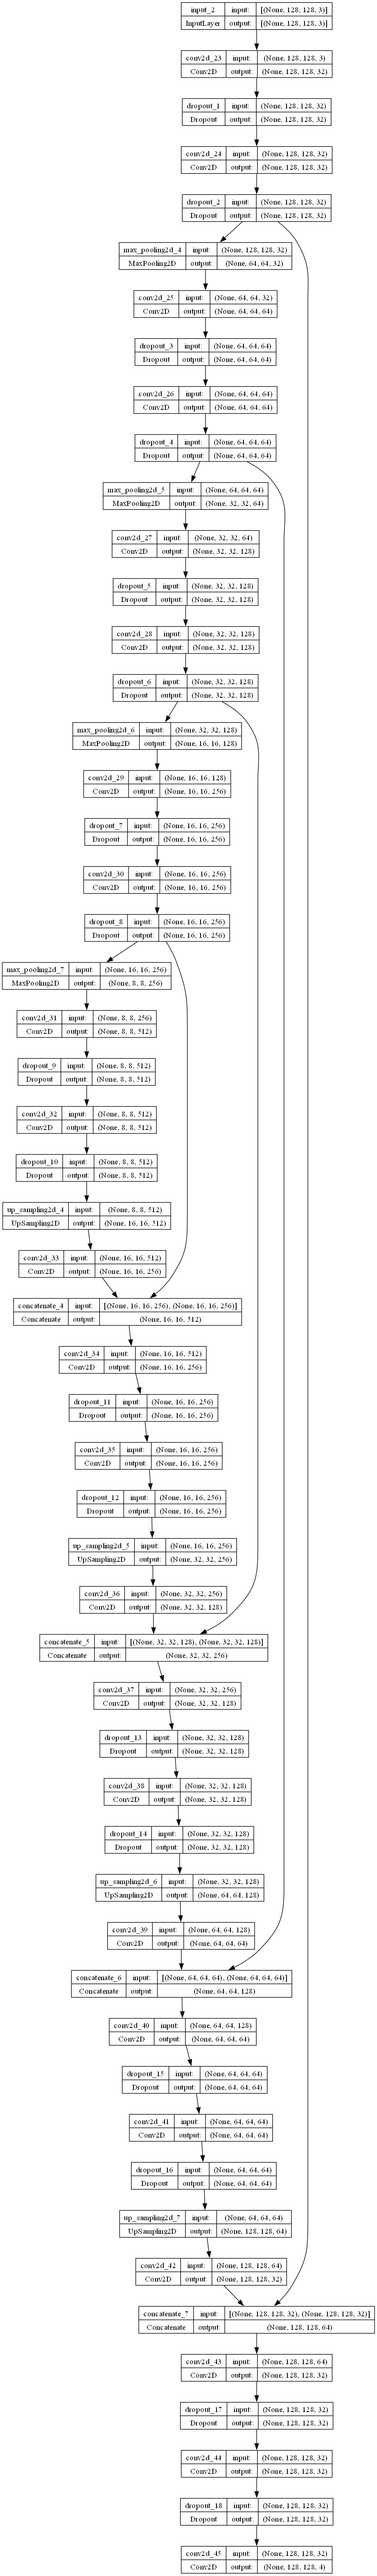

In [10]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 100)